In [1]:
import import_ipynb
from Utils import *

importing Jupyter notebook from Utils.ipynb


In [2]:
import pandas as pd
import numpy as np

daily_treasury_yield_curve_rate_df = pd.read_csv('daily_treasury_yield_curve_rate.csv',
                                                 parse_dates=['Date'], index_col='Date')
baa10y_df = pd.read_csv('BAA10Y.csv', parse_dates=['DATE'], index_col='DATE')

# Prepare data

In [10]:
PERIODS = ['3 Mo', '1 Yr', '5 Yr', '10 Yr', '30 Yr']
TRAIN_START_DATE = '1992-01-01'
TRAIN_END_DATE = VAL_START_DATE =  '1992-12-31'
VAL_END_DATE = TEST_START_DATE =  '1993-06-01'
TEST_END_DATE =  '1994-01-01'

In [11]:
data_df = create_data_df(use='dataset', start_date=TRAIN_START_DATE, end_date='1995-01-01') 

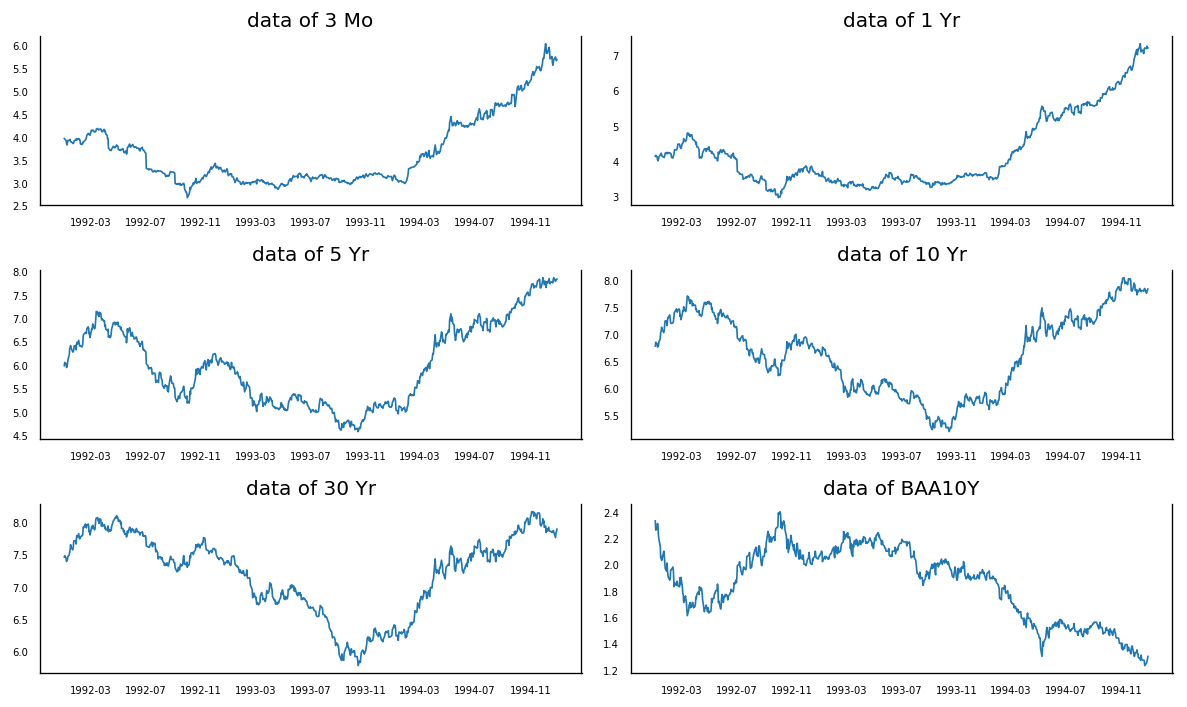

In [12]:
PERIODS = PERIODS + ['BAA10Y']
plot_data(data_df, 'data')

It appears that for several time series, in train set all the samples get label 0. Meaning that for all samples
the value of the interest in a year ahead will be always smaller than the sample value.

For 1 year there is a need to find another time period since we can not train classifier that gets in the train set only 1 class
for all samples.

# Prepare labels

In [13]:
day_label_df = pd.DataFrame()
month_label_df = pd.DataFrame()
year_label_df = pd.DataFrame()

day_shift=1
month_shift = data_df.loc['1992-01-01':'1992-02-01'].shape[0]-1
year_shift = data_df.loc['1992-01-01':'1993-01-01'].shape[0]

for idx, period in enumerate(PERIODS):
    ts = data_df[period]
    
    day_shifted_ts = data_df[period].shift(-1)
    month_shifted_ts = data_df[period].shift(-month_shift)
    year_shifted_ts = data_df[period].shift(-year_shift)

    day_label = pd.Series(data=np.where(day_shifted_ts > ts, 1, 0), index=ts.index)
    month_label = pd.Series(data=np.where(month_shifted_ts > ts, 1, 0), index=ts.index)
    year_label = pd.Series(data=np.where(year_shifted_ts > ts, 1, 0), index=ts.index)
    
    day_label_df = add_column_to_df(day_label_df,'day_{period}_label'.format(period=period), day_label)
    month_label_df = add_column_to_df(month_label_df,'month_{period}_label'.format(period=period), month_label)
    year_label_df = add_column_to_df(year_label_df,'year_{period}_label'.format(period=period), year_label)
    
day_label_df = day_label_df.dropna()
month_label_df = month_label_df.dropna()
year_label_df = year_label_df.dropna()

# Run classification models on validation set

In [14]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

features = PERIODS + ['mean', 'std']
def print_confusion_matrix(y_pred, y_true, model_name, period, print_confusion=False):
    if print_confusion:
        print('Confusion matrix for {model}:\n'.format(model=model_name, period=period))
        print(period + '\n')
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        print('True Negative: {tn}'.format(tn=tn))
        print('False Positive: {fp}'.format(fp=fp))
        print('False Negative: {fn}'.format(fn=fn))
        print('True Positive: {tp}'.format(tp=tp))
        print('\n')
        
def run(time, labels_df, periods, models, print_confusion=False):
    train_df = data_df.loc[TRAIN_START_DATE:TRAIN_END_DATE]
    val_df = data_df.loc[VAL_START_DATE:VAL_END_DATE]
    
    results_df = pd.DataFrame(index=models.keys())
    for idx, period in enumerate(periods):
        period_result = []
        for model_name, model in models.items():
            label = '{time}_{period}_label'.format(time=time, period=period)
            rolling_data_df = data_df
            rolling_data_df['mean'] = data_df[period].rolling(window=month_shift).mean()
            rolling_data_df['std'] = data_df[period].rolling(window=month_shift).std()
            rolling_train_df = rolling_data_df.loc[TRAIN_START_DATE:TRAIN_END_DATE]
            rolling_val_df = rolling_data_df.loc[VAL_START_DATE:VAL_END_DATE]
            rolling_train_df = rolling_train_df.dropna()
            rolling_val_df = rolling_val_df.dropna()
            if labels_df[label].loc[rolling_train_df.index[0]:rolling_train_df.index[-1]].values.sum() == 0:
                period_result.append(np.nan)
                continue
            fitted_model = model.fit(X=rolling_train_df[features].values, 
                                     y=labels_df[label].loc[rolling_train_df.index[0]:rolling_train_df.index[-1]].values)
            y_predict = pd.DataFrame(data=fitted_model.predict(rolling_val_df[features]).reshape(-1,1), columns=['Prediction'])
            y_true = labels_df[label].loc[VAL_START_DATE:VAL_END_DATE]
            period_result.append(accuracy_score(y_predict, y_true))
            print_confusion_matrix(y_predict, y_true, model_name, period, print_confusion)
            
        results_df = add_column_to_df(results_df, period, period_result)   
    return results_df


In [15]:
C=1.0
models = ({'svm_1': svm.SVC(kernel='linear', C=C),
          'svm_2': svm.LinearSVC(C=C, max_iter=10000),
          'svm_3': svm.SVC(kernel='rbf', gamma=0.7, C=C),
          'svm_4': svm.SVC(kernel='poly', degree=3, gamma='auto', C=C),
          'LogisticRegression': LogisticRegressionCV(cv=5, random_state=0),
          'SDG': linear_model.SGDClassifier(loss='modified_huber', max_iter=10000, tol=1e-3)})


In [16]:
day_results_df = run('day', day_label_df, PERIODS, models)
month_results_df = run('month', month_label_df, PERIODS, models)
year_results_df = run('year', year_label_df, PERIODS, models)
print('Prediction for next day:')
print('-'*100)
print(day_results_df)
print('\nPrediction for next month:')
print('-'*100)
print(month_results_df)
print('\nPrediction for next year:')
print('-'*100)
print(year_results_df)

Prediction for next day:
----------------------------------------------------------------------------------------------------
                        3 Mo      1 Yr      5 Yr     10 Yr     30 Yr    BAA10Y
svm_1               0.615385  0.548077  0.567308  0.596154  0.548077  0.509615
svm_2               0.519231  0.509615  0.451923  0.538462  0.596154  0.519231
svm_3               0.615385  0.586538  0.557692  0.596154  0.615385  0.509615
svm_4               0.615385  0.548077  0.567308  0.596154  0.548077  0.576923
LogisticRegression  0.615385  0.548077  0.567308  0.596154  0.548077  0.528846
SDG                 0.384615  0.451923  0.567308  0.596154  0.451923  0.490385

Prediction for next month:
----------------------------------------------------------------------------------------------------
                        3 Mo      1 Yr      5 Yr     10 Yr     30 Yr    BAA10Y
svm_1               0.490385  0.625000  0.711538  0.692308  0.682692  0.500000
svm_2               0.490385  0.62

It can be seen that for each time series that we try to predict there is different algorithm that yields the best results. 
For example, when predicting next day increase in interest rate of 3 months, 
the best algorithm is svm_2 (Linear SVC) which got 63% accuracy on the validation set.

Furthermore, when trying to predict increase or decrease of interest rate an year in advanced, in several time series all samples got the same label, meaning that for these time series, for each sample, in the next year the value of the interest rate was lower than the current value. (can see that the value is lower obsrving the plots shown above).

In [62]:
year_models = ({'svm_1': svm.SVC(kernel='linear', C=C, class_weight='balanced'),
          'svm_2': svm.LinearSVC(C=C, max_iter=10000, class_weight='balanced'),
          'svm_3': svm.SVC(kernel='rbf', gamma=0.7, C=C, class_weight='balanced'),
          'svm_4': svm.SVC(kernel='poly', degree=3, gamma='auto', C=C, class_weight='balanced'),
          'LogisticRegression': LogisticRegressionCV(cv=5, random_state=2, class_weight='balanced'),
          'SDG': linear_model.SGDClassifier(loss='modified_huber',
                                            random_state=2, max_iter=10000, tol=1e-3, class_weight='balanced')})
periods = ['3 Mo', '1 Yr', 'BAA10Y']
run('year', year_label_df, periods, year_models, True)

Confusion matrix for svm_1:

3 Mo

True Negative: 7
False Positive: 8
False Negative: 12
True Positive: 77


Confusion matrix for svm_2:

3 Mo

True Negative: 8
False Positive: 7
False Negative: 44
True Positive: 45


Confusion matrix for svm_3:

3 Mo

True Negative: 13
False Positive: 2
False Negative: 7
True Positive: 82


Confusion matrix for svm_4:

3 Mo

True Negative: 4
False Positive: 11
False Negative: 38
True Positive: 51


Confusion matrix for LogisticRegression:

3 Mo

True Negative: 4
False Positive: 11
False Negative: 35
True Positive: 54


Confusion matrix for SDG:

3 Mo

True Negative: 15
False Positive: 0
False Negative: 24
True Positive: 65


Confusion matrix for svm_1:

1 Yr

True Negative: 4
False Positive: 1
False Negative: 5
True Positive: 94


Confusion matrix for svm_2:

1 Yr

True Negative: 5
False Positive: 0
False Negative: 15
True Positive: 84


Confusion matrix for svm_3:

1 Yr

True Negative: 2
False Positive: 3
False Negative: 4
True Positive: 95


Confusi

,3 Mo,1 Yr,BAA10Y
svm_1,0.807692,0.942308,1.000000
svm_2,0.509615,0.855769,1.000000
svm_3,0.913462,0.932692,1.000000
svm_4,0.528846,0.951923,1.000000
LogisticRegression,0.557692,0.951923,1.000000
SDG,0.769231,0.951923,0.990385


Since we know that for several time series, for all samples the values of the interest in a year is lower than the current value, we can assume that for most interest of 1 year and interest of the spread most sample fall on to these class as well.
I added the class_weight option adjust the weights proportionally to the samples in each class.
As can be seen, using this option improved the predictions for several methods.

Using the balanced weights imporved the prediction accuracy of several models on the 3 month and 1 year time series 
on the task of predicting increase or decrease of interest value in 1 year.
It is intresting to see if applying these on the tasks of predicting increase or decrease in 1 month and in 1 day 
can improve the accuracy as well. 
lets see the data distribution for 1 day and 1 month in order to evaluate if the classes are balanced:

In [34]:
def check_balance(label_df, time):
    print(time)
    for period in PERIODS:
        print(period)
        label = '{time}_{period}_label'.format(period=period, time=time)
        print('class 0: {}'.format(1-float(label_df[label].sum())/label_df.shape[0]))
        print('class 1: {}'.format(float(label_df[label].sum())/label_df.shape[0]))
        
check_balance(day_label_df, 'day')
check_balance(month_label_df, 'month')

day
3 Mo
class 0: 0.596
class 1: 0.404
1 Yr
class 0: 0.552
class 1: 0.448
5 Yr
class 0: 0.54
class 1: 0.46
10 Yr
class 0: 0.5626666666666666
class 1: 0.43733333333333335
30 Yr
class 0: 0.5573333333333333
class 1: 0.44266666666666665
BAA10Y
class 0: 0.5826666666666667
class 1: 0.41733333333333333
month
3 Mo
class 0: 0.46399999999999997
class 1: 0.536
1 Yr
class 0: 0.44133333333333336
class 1: 0.5586666666666666
5 Yr
class 0: 0.48
class 1: 0.52
10 Yr
class 0: 0.5093333333333334
class 1: 0.49066666666666664
30 Yr
class 0: 0.528
class 1: 0.472
BAA10Y
class 0: 0.6253333333333333
class 1: 0.37466666666666665


In [104]:
def test(time, labels_df, algorithms, models):
    train_df = data_df.loc[TRAIN_START_DATE:VAL_END_DATE]
    test_df = data_df.loc[TEST_START_DATE:TEST_END_DATE]
    
    results=[]
    results_df = pd.DataFrame(index=algorithms.index)
    for period, algorithm in algorithms.iteritems():
        if algorithm not in models.keys():
            results.append(np.nan)
            continue
        
        label = '{time}_{period}_label'.format(time=time, period=period)
        rolling_data_df = data_df
        rolling_data_df['mean'] = data_df[period].rolling(window=month_shift).mean()
        rolling_data_df['std'] = data_df[period].rolling(window=month_shift).std()
        rolling_train_df = rolling_data_df.loc[TRAIN_START_DATE:VAL_END_DATE]
        rolling_test_df = rolling_data_df.loc[TEST_START_DATE:TEST_END_DATE]
        rolling_train_df = rolling_train_df.dropna()
        rolling_test_df = rolling_test_df.dropna()
        if labels_df[label].loc[rolling_train_df.index[0]:rolling_train_df.index[-1]].values.sum() == 0:
            period_result.append(np.nan)
            continue
        model = models[algorithm]
        fitted_model = model.fit(X=rolling_train_df[features].values, 
                                 y=labels_df[label].loc[rolling_train_df.index[0]:rolling_train_df.index[-1]].values)
        y_predict = pd.DataFrame(data=fitted_model.predict(rolling_test_df[features]).reshape(-1,1), columns=['Prediction'])
        y_true = labels_df[label].loc[TEST_START_DATE:TEST_END_DATE]
        results.append(accuracy_score(y_predict, y_true))
    results_df = add_column_to_df(results_df, time, results)   
    return results_df

As can be seen, the classes are balanced in most time series in both tasks. (Except for the spread in the month task)

In [105]:
C=1.0
models = ({'svm_1': svm.SVC(kernel='linear', C=C),
          'svm_2': svm.LinearSVC(C=C, max_iter=10000),
          'svm_3': svm.SVC(kernel='rbf', gamma=0.7, C=C),
          'svm_4': svm.SVC(kernel='poly', degree=3, gamma='auto', C=C),
          'LogisticRegression': LogisticRegressionCV(cv=5, random_state=0),
          'SDG': linear_model.SGDClassifier(loss='modified_huber', max_iter=10000, tol=1e-3)})


In [106]:
def algorithms_for_test(results_df):
    return results_df.idxmax(axis=0)
    
algo_day = algorithms_for_test(day_results_df)
res_day = test('day', day_label_df, algo_day, models)
algo_month = algorithms_for_test(month_results_df)
res_month = test('month', month_label_df, algo_month, models)
algo_year = algorithms_for_test(year_results_df)
res_year = test('year', year_label_df, algo_year, year_models)
print(res_day)
print(res_month)
print(res_year)

             day
3 Mo    0.662162
1 Yr    0.608108
5 Yr    0.567568
10 Yr   0.621622
30 Yr   0.439189
BAA10Y  0.560811
           month
3 Mo    0.398649
1 Yr    0.432432
5 Yr    0.533784
10 Yr   0.554054
30 Yr   0.648649
BAA10Y  0.601351
            year
3 Mo    0.986486
1 Yr    0.986486
5 Yr         NaN
10 Yr        NaN
30 Yr        NaN
BAA10Y  1.000000
